In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import numpy as np
plt.style.use(['seaborn-colorblind','paper'])
plt.style.use('classic')
import Cosmology as Cosmo
from scipy.integrate import simps
from scipy.interpolate import interp1d

In [27]:
def dNdz_LSST(bin_num,dn_filename = 'dndz_LSST_i27_SN5_3y'):
    bins,big_grid,res   = pickle.load(open(dn_filename+'_extrapolated.pkl','r'))
    mbin                = bins[bin_num]
    zbin                = big_grid
    nbin                = res[bin_num]
    norm                = simps(nbin,zbin)
    dndz                = interp1d(zbin, nbin/norm, kind='linear',bounds_error=False,fill_value=0.)
    print 'using z-bin', mbin
    plt.figure()
    plt.plot(zbin,nbin)
    plt.show()
    return norm

In [48]:
"""------------settings----------------"""
bin_num     = 0

fsky        = 0.5

L = np.arange(10,3000)

params      = Cosmo.Planck2015
tag         = params[0]['name']
nl          = True

N0_path     ='/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/N0files/'
spec_path   ='/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/power_spectra/'
ellpath     ='/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/ells/'
ellfile     ='ell_ang_full_Lmin1_Lmax3000_lmin1_lmax8000_lenL120_lenl140_lenang120_1e-04.pkl'
path        ='/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/noise_curves/'

#bispectrum code
config_kk = 'kk'
config_kg = 'kg'
config_gg = 'gg'
Lmin = 1
Lmax = 3000

thetaFWHMarcmin = 1. #beam FWHM
noiseUkArcmin   = 1. #eval(sys.argv[1]) #Noise level in uKarcmin
l_max_T         = 3000
l_max_P         = 5000
l_min           = 50
L_max           = 6000 #for l integration
L_min           = 1
TCMB            = 2.7255e6
div             = False #divide EB by factor of 2.5

if l_max_T!=l_max_P:
    lmax='mixedlmax_%d_%d'%(l_max_T,l_max_P)
else:
    lmax=str(l_max_T)

if nl:
  nl_='_nl'
else:
  nl_=''

if div:
    print 'Dividing EB by factor 2.5!'
    no_div='div25'
else:
    no_div='nodiv'

In [49]:
print N0_path+'%s_N0_%s_%d_%d%d_%s%s.pkl'%(tag,lmax,l_min,10*noiseUkArcmin,10*thetaFWHMarcmin,no_div,nl_)
filename=N0_path+'%s_N0_%s_%d_%d%d_%s%s.pkl'%(tag,lmax,l_min,10*noiseUkArcmin,10*thetaFWHMarcmin,no_div,nl_)
Ls,AL = pickle.load(open(filename,'r'))

/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/N0files/Planck2015_N0_mixedlmax_3000_5000_50_1010_nodiv_nl.pkl


In [50]:
#percent accuracy, should be sufficient for this
config_kk+="_full_"+tag
tag = "_"+"LSSTbin"+str(bin_num)+'_full_'+tag
config_kg+=tag
config_gg+=tag

ll, l, theta = pickle.load(open(ellpath+ellfile,'r'))
clgg = np.load(spec_path+"CL_%s_Lmin%d-Lmax%d_%s.npy"%(config_gg,Lmin,Lmax-1,'halofit'))
clgg = np.interp(L,ll,clgg)
clkg = np.load(spec_path+"CL_%s_Lmin%d-Lmax%d_%s.npy"%(config_kg,Lmin,Lmax-1,'halofit'))
clkg = np.interp(L,ll,clkg)
clkk = np.load(spec_path+"CL_%s_Lmin%d-Lmax%d_%s.npy"%(config_kk,Lmin,Lmax-1,'halofit'))
clkk = np.interp(L,ll,clkk)

using z-bin [0, 0.5, 0.03]


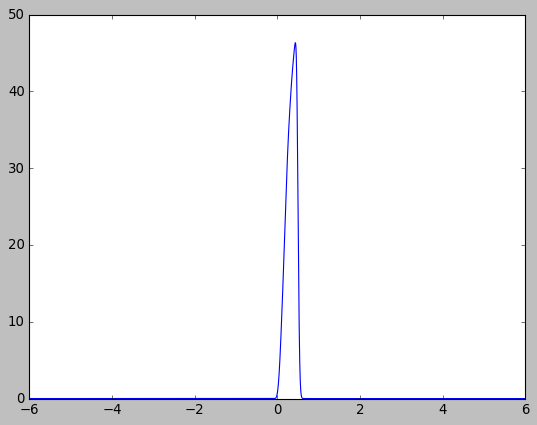

using z-bin [0, 0.5, 0.03]


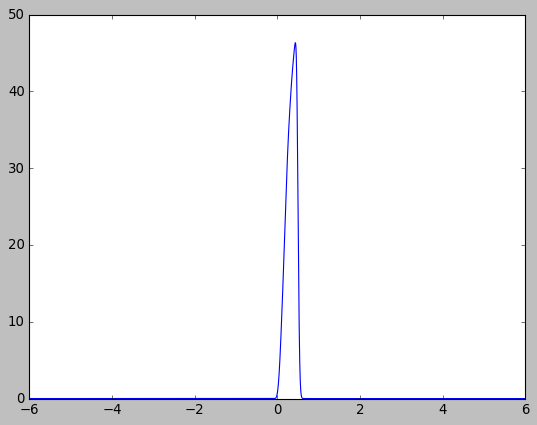

(14.32276056640902, 169267857.61357921)
/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/noise_curves/Gaussian_variances_CMB-S4_lmax30005000__LSSTbin0_full_Planck2015_dndz_LSST_i27_SN5_3y.pkl
[  10   11   12 ..., 2997 2998 2999]


In [51]:
n0  = np.interp(L,Ls,1./4.*Ls**2*AL['eb'])
n_bar = dNdz_LSST(bin_num)*(180*60/np.pi)**2
print( dNdz_LSST(bin_num),n_bar)

noise_kk      = np.sqrt((2./(2.*L+1.)/fsky)*(clkk+n0)**2)
noise_gg      = np.sqrt((2./(2.*L+1.)/fsky)*(clgg+1./n_bar)**2)
noise_kg      = 1./(2*L+1.)/fsky*((clkk+n0)*(clgg+1./n_bar)+clkg**2)
noise_kg      = np.sqrt(noise_kg)

pickle.dump([L,clgg,clkg,clkk,noise_gg,noise_kg,noise_kk],open(path+'Gaussian_variances_CMB-S4_lmax30005000_%s_%s.pkl'%(tag,'dndz_LSST_i27_SN5_3y'),'w'))
print(path+'Gaussian_variances_CMB-S4_lmax30005000_%s_%s.pkl'%(tag,'dndz_LSST_i27_SN5_3y'))
print(L)

In [52]:
tag

'_LSSTbin0_full_Planck2015'